# Data statistics

In [51]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

#Home made functions
import Utilities #Does not work....

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = -1 #Maximal number of cores in use
extension = '.png' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
#DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop
CASE = 'Bentheimer1000'
#####Reference values and ranges for filename generation#####
UREF = 4.6E-06
TREF = 2.92E+01
def v_to_s(v) :
    if v == 0 :
        return 'Inf'
    else :
        return '%.1E' % v

def v_to_d(v) :
    return '%.2f' % v
    
def v_to_pow(v) :
    if v == 0 :
        return r'$\infty$'
    else :
        power  = int(np.log10(v))
        factor = int(v/10.0**power)
        if factor == 1.0 :
            return r'$10^{'+str(power)+'}$'
        else :
            return str(factor)+r'$\times 10^{'+str(power)+'}$'

def print_keys(dict_) :
    for key in dict_ : print(key)
    return

In [52]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

def time_step_analysis(t_ssl,key) :
    dt         = [t1-t0 for (t1,t0) in zip(t_ssl[1:],t_ssl[:-1]) if t1-t0 > 0]
    dt_hist    = Extract_pdf(dt,50)
    dtDNS_mean = np.mean(dt)
    dtDNS_std  = np.std(dt)
    return (key, dt_hist, dtDNS_mean, dtDNS_std)
    
def parallel_time_step_analysis(t_dict) :
    dt_hist        = {}
    dtDNS_mean     = {}
    dtDNS_std      = {}
    results  = Parallel(n_jobs=NCORES_MAX)(delayed(time_step_analysis)(t_dict[key],key) for key in KEYS)
    for (k_,h_,m_,s_) in results :
        dt_hist[k_]    = h_.tolist()
        dtDNS_mean[k_] = [m_]
        dtDNS_std[k_]  = [s_]
    return dt_hist, dtDNS_mean, dtDNS_std

## Some useful functions to handle pdf
def Save_pdf(pdf_dict, filename) :
    #Copy data into non np array dict for json formating
    x = {}
    y = {}
    for key in pdf_dict : x[key] = [v for v in pdf_dict[key][0]]
    for key in pdf_dict : y[key] = [v for v in pdf_dict[key][1]]
    with open(filename, 'w') as outfile:  
        json.dump([x,y], outfile)
        
def Load_pdf(filename) :
    x = {}
    y = {} 
    pdf_ = {}
    with open(filename, 'r') as outfile:  
        data = json.load(outfile)
    x = data[0]
    y = data[1]
    for key in x : pdf_[key] = [np.array(x[key]),np.array(y[key])]    
    return pdf_

def Extract_pdf(data_, nbins = 500, dst = True) :
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

def Return_skew(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu   = Return_mean(pdf_)
    std  = Return_std(pdf_)
    skew = np.sum([((x_ - mu)/std)**3*y_ for (x_,y_) in zip(x,y)])/np.sum(y)
    return skew

def mean_crossing_time(tdata) :
    T_  = []
    tm1 = 0
    for t_ in tdata :
        if tm1 > t_ : #If time is set to zero again (= end of the stream line)
            T_.append(tm1)
        tm1 = t_
    N_  = len(T_)
    mean_ = sum(T_)/N_
    return mean_



In [53]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

# Loading rough and processed data

#### Data files 

In [54]:
DATA = {}

SAMPLE = 'Bentheimer 1000'
PECLET = [0, 1e3, 1e2, 1e1]
SLSM   = [20000, 20000, 20000, 20000]
CSF    = [1, 1, 1, 1]
KEYS   = []
for (Pe_, slsm_, csf_) in zip(PECLET, SLSM, CSF) : 
    name_ = DIR+CASE+'/Particle_Tracking/sl_out_Pe'+v_to_s(Pe_)+'_SLSM'+v_to_s(slsm_)+'_TMAX0_CSF'+str(csf_)+'.dat'
    key_  = 'Pe='+v_to_pow(Pe_)+', SLSM='+v_to_pow(slsm_)+', CSF='+str(csf_)
    DATA[key_] = name_
    KEYS.append(key_)

PLOT_KEYS = KEYS

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('Dataset to load : ' +str(len(DATA)))

PARAM = {}
param = ['Pe','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key], param)
    
for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + ' :')
        print('\t' + DATA[key])
        print('not found')

Dataset to load : 4


In [55]:
for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + 'not found')

## Probability density functions

#### DNS directional velocities pdf and mean velocity for different diffusion coefficients

In [56]:
Umean  =1.0; SAVE = False
pvx_DNS = {}; vxmean = []; vxstd = []; pdfvxfname = DIR+'Processed_data/pdf_vx.dat'
pvy_DNS = {}; vymean = []; vystd = []; pdfvyfname = DIR+'Processed_data/pdf_vy.dat'
pvz_DNS = {}; vzmean = []; vzstd = []; pdfvzfname = DIR+'Processed_data/pdf_vz.dat'
print('Loading directional velocity pdf..')
print('\t vx')
pvx_DNS = Load_pdf(pdfvxfname)
print('\t vy')
pvy_DNS = Load_pdf(pdfvyfname)
print('\t vz')
pvz_DNS = Load_pdf(pdfvzfname)
print('Done')

vxmean = []; vxstd = [];
vymean = []; vystd = [];
vzmean = []; vzstd = [];
print('Computing mean and std..')
for key in KEYS :
    vxmean.append(Return_mean(pvx_DNS[key]))
    vymean.append(Return_mean(pvy_DNS[key]))
    vzmean.append(Return_mean(pvz_DNS[key]))
    vxstd.append(Return_std(pvx_DNS[key]))
    vystd.append(Return_std(pvy_DNS[key]))
    vzstd.append(Return_std(pvz_DNS[key]))
print('Done.')

Loading directional velocity pdf..
	 vx
	 vy
	 vz
Done
Computing mean and std..
Done.


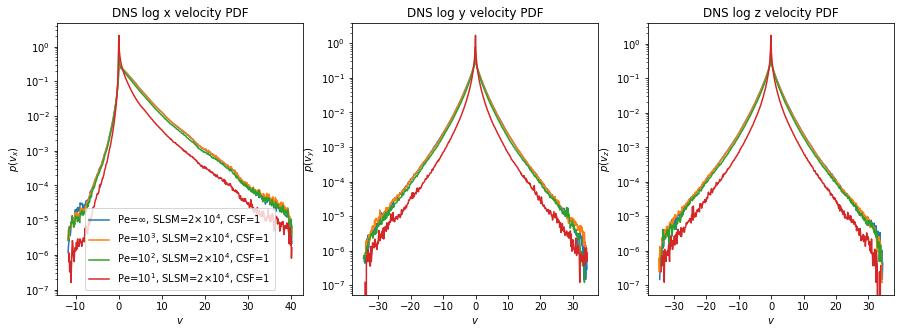

In [57]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

ax = axs[0]
ax.set_title('DNS log x velocity PDF')
for key in PLOT_KEYS : ax.semilogy(pvx_DNS[key][0], pvx_DNS[key][1],label = key)
ax.legend();
ax.set_xlabel(r'$v$');
ax.set_ylabel(r'$p(v_x)$');

ax = axs[1]
ax.set_title('DNS log y velocity PDF')
for key in PLOT_KEYS : ax.semilogy(pvy_DNS[key][0], pvy_DNS[key][1],label = key)
ax.set_xlabel(r'$v$');
ax.set_ylabel(r'$p(v_y)$');

ax = axs[2]
ax.set_title('DNS log z velocity PDF')
for key in PLOT_KEYS : ax.semilogy(pvz_DNS[key][0], pvz_DNS[key][1],label = key)
ax.set_xlabel(r'$v$');
ax.set_ylabel(r'$p(v_z)$');
plt.savefig(DIR+'Figures/directional_speed_pdf'+extension)

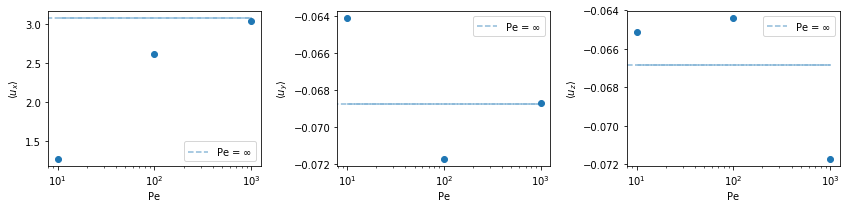

In [58]:
fig, axs = plt.subplots(1,3, figsize = (12, 3))

ax = axs[0]
for i_ in range(len(PECLET)) :
    Pe_ = PECLET[i_]

    if Pe_  == 0 :
        ax.plot(PECLET, [vxmean[i_] for pp in PECLET], '--', color = color_cycle[0], label = 'Pe = '+v_to_pow(Pe_), alpha = 0.5)
    else :
        ax.plot(Pe_, vxmean[i_], 'o', color = color_cycle[0])
ax.set_xlabel('Pe')
ax.set_ylabel(r'$\langle u_x \rangle$')
ax.set_xscale('log')
ax.legend()

ax = axs[1]
for i_ in range(len(PECLET)) :
    Pe_ = PECLET[i_]

    if Pe_  == 0 :
        ax.plot(PECLET, [vymean[i_] for pp in PECLET], '--', color = color_cycle[0], label = 'Pe = '+v_to_pow(Pe_), alpha = 0.5)
    else :
        ax.plot(Pe_, vymean[i_], 'o', color = color_cycle[0])
ax.set_xlabel('Pe')
ax.set_ylabel(r'$\langle u_y \rangle$')
ax.set_xscale('log')
ax.legend()

ax = axs[2]
for i_ in range(len(PECLET)) :
    Pe_ = PECLET[i_]

    if Pe_  == 0 :
        ax.plot(PECLET, [vzmean[i_] for pp in PECLET], '--', color = color_cycle[0], label = 'Pe = '+v_to_pow(Pe_), alpha = 0.5)
    else :
        ax.plot(Pe_, vzmean[i_], 'o', color = color_cycle[0])
ax.set_xlabel('Pe')
ax.set_ylabel(r'$\langle u_z \rangle$')
ax.set_xscale('log')
ax.legend()

plt.tight_layout()
plt.savefig(DIR+'Figures/directional_speed_mean'+extension)

### Log velocity magnitude PDF

In [59]:
pdf_vDNS     = {} #Log velocity magnitude probability density function extracted directly from DNS
pdf_vDNS_fname = DIR+'Processed_data/pdf_vDNS.dat'
pdf_viso     = {} #to store isochronous histogram as a line
pdf_viso_fname = DIR+'Processed_data/pdf_viso.dat'
    
print('Loading vDNS pdf..')
pdf_vDNS = Load_pdf(pdf_vDNS_fname)
print('Loading viso pdf..')
pdf_viso = Load_pdf(pdf_viso_fname)

vmean_iso   = [] #Mean log velocity magnitude
vstd_iso    = [] #Standard deviation
vskew_iso   = [] #Skewness
vmean_DNS   = [] #Mean log velocity magnitude
vstd_DNS    = []
vskew_DNS   = [] #Skewness

for key in KEYS :
    vmean_iso.append(Return_mean(pdf_viso[key]))
    vstd_iso.append(Return_std(pdf_viso[key]))
    vskew_iso.append(Return_skew(pdf_viso[key]))
    vmean_DNS.append(Return_mean(pdf_vDNS[key]))
    vstd_DNS.append(Return_std(pdf_vDNS[key]))
    vskew_DNS.append(Return_skew(pdf_vDNS[key]))
print('Done.')

Loading vDNS pdf..
Loading viso pdf..
Done.


In [60]:
print(PARAM[key])

{'Pe': 10.0, 'SLSM': 20000.0, 'TMAX': 0.0, 'CSF': 1.0}


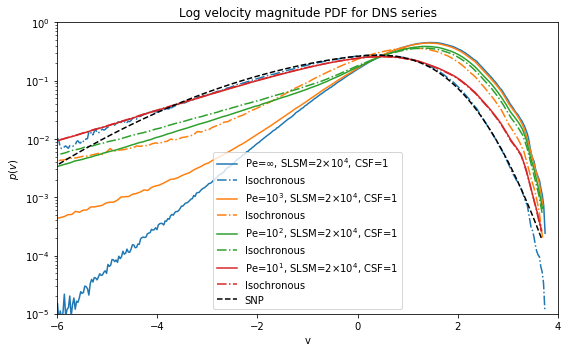

In [61]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('DNS log velocity magnitude PDF')
ax.set_title('Log velocity magnitude PDF for DNS series');
ax.set_xlabel('v')
ax.set_ylabel(r'$p(v)$')

m_=0
for key in PLOT_KEYS : 
    ax.plot(pdf_vDNS[key][0],pdf_vDNS[key][1], label=key, color = color_cycle[m_]);
    ax.plot(pdf_viso[key][0],pdf_viso[key][1], '-.', label='Isochronous', color = color_cycle[m_]);
    m_ += 1

ax.plot(pdf_vDNS[key][0], p_skew(pdf_vDNS[key][0],Bentheimer1000), '--k', label = 'SNP');
ax.legend();
ax.set_xlim([-6,4]);
ax.set_ylim([1e-5, 1])
ax.set_yscale('log')
    
plt.tight_layout()
plt.savefig(DIR+'Figures/DNS_vs_iso_large_range'+extension)

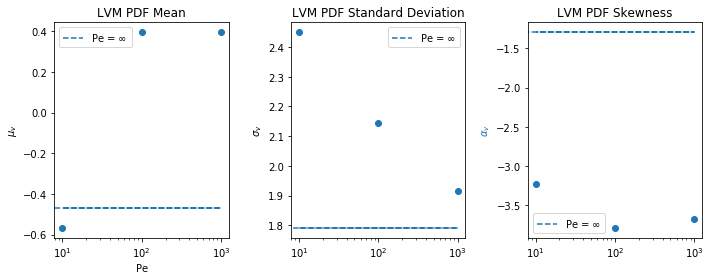

In [62]:
fig, axs = plt.subplots(1,3,figsize=(10,4))

ax = axs[0]
ax.set_title('LVM PDF Mean')
for i_ in range(len(PECLET)) :
    Pe_ = PECLET[i_]
    vm_ = vmean_iso[i_]
    if Pe_ == 0 : 
        ax.semilogx(PECLET,[vm_ for pp in PECLET],'--', color = color_cycle[0], label = 'Pe = '+v_to_pow(Pe_))
    else :
        ax.semilogx(Pe_,vm_,'o', color = color_cycle[0])
ax.set_xlabel('Pe');
ax.set_ylabel(r'$\mu_v$')
ax.legend();

ax = axs[1]
ax.set_title('LVM PDF Standard Deviation')
for i_ in range(len(PECLET)) :
    Pe_ = PECLET[i_]
    vm_ = vstd_iso[i_]
    if Pe_ == 0 : 
        ax.semilogx(PECLET,[vm_ for pp in PECLET],'--', color = color_cycle[0], label = 'Pe = '+v_to_pow(Pe_))
    else :
        ax.semilogx(Pe_,vm_,'o', color = color_cycle[0])
ax.set_ylabel(r'$\sigma_v$')
ax.legend();

ax = axs[2]
ax.set_title('LVM PDF Skewness')
for i_ in range(len(PECLET)) :
    Pe_ = PECLET[i_]
    vm_ = vskew_iso[i_]
    if Pe_ == 0 : 
        ax.semilogx(PECLET,[vm_ for pp in PECLET],'--', color = color_cycle[0], label = 'Pe = '+v_to_pow(Pe_))
    else :
        ax.semilogx(Pe_,vm_,'o', color = color_cycle[0])
ax.set_ylabel(r'$\alpha_v$', color = color_cycle[0])
ax.legend();

plt.tight_layout()
plt.savefig(DIR+'Figures/mean_v_to_dm'+extension)

###  Theta analysis

In [63]:
pdf_thetaDNS       = {} #Directional angle probability density function extracted directly from DNS
pdf_thetaDNS_fname = DIR+'Processed_data/pdf_thetaDNS.dat'
pdf_thetaiso       = {} 
pdf_thetaiso_fname = DIR+'Processed_data/pdf_thetaiso.dat'
pdf_thetaeq        = {} 
pdf_thetaeq_fname  = DIR+'Processed_data/pdf_thetaeq.dat'

print('Loading thetaDNS pdf..')
pdf_thetaDNS = Load_pdf(pdf_thetaDNS_fname)
 
print('Loading thetaiso pdf..')
pdf_thetaiso = Load_pdf(pdf_thetaiso_fname)

print('Loading thetaeq pdf..')
pdf_thetaeq = Load_pdf(pdf_thetaeq_fname)

Loading thetaDNS pdf..
Loading thetaiso pdf..
Loading thetaeq pdf..


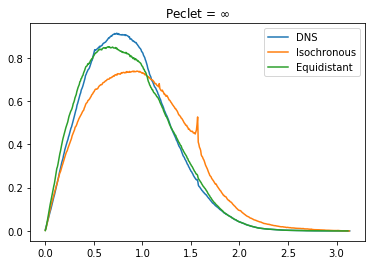

In [66]:
i = 0
key = KEYS[i]
plt.title('Peclet = ' + v_to_pow(PECLET[i]))
plt.plot(pdf_thetaDNS[key][0],pdf_thetaDNS[key][1], label = 'DNS');
plt.plot(pdf_thetaiso[key][0],pdf_thetaiso[key][1], label = 'Isochronous');
plt.plot(pdf_thetaeq[key][0],pdf_thetaeq[key][1], label = 'Equidistant');
plt.legend();

(0, 3.141592653589793)

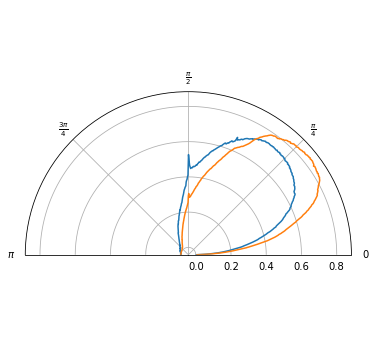

In [67]:
plt.figure(figsize=(6,6))
plt.polar(pdf_thetaiso[KEYS[0]][0],pdf_thetaiso[KEYS[0]][1])
plt.polar(pdf_thetaeq[KEYS[1]][0],pdf_thetaeq[KEYS[1]][1])
xT=plt.xticks()[0]
xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
plt.xticks(xT, xL)
plt.xlim([0,np.pi])

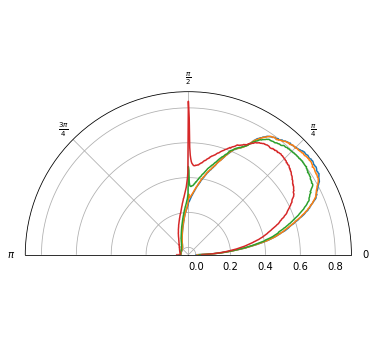

In [68]:
plt.figure(figsize=(6,6))
for key in KEYS : plt.polar(pdf_thetaeq[key][0],pdf_thetaeq[key][1])
xT=plt.xticks()[0]
xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
plt.xticks(xT, xL)
plt.xlim([0,np.pi]);

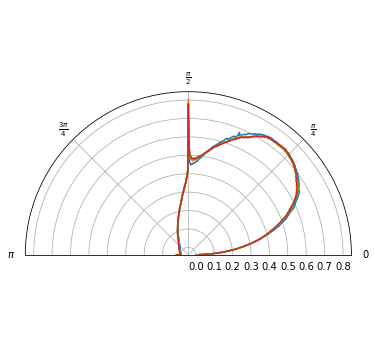

In [69]:
plt.figure(figsize=(6,6))
for key in KEYS : plt.polar(pdf_thetaiso[key][0],pdf_thetaiso[key][1])
xT=plt.xticks()[0]
xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
plt.xticks(xT, xL)
plt.xlim([0,np.pi]);

#### Autocorrelation

We compute autocorrelation using the normalized estimator : 
$$\hat R(k) = \frac{1}{n-k} \sum_{t=1}^{n-k} \left(\frac{X_t-\mu_Y}{\sigma_X}\right)\left(\frac{Y_t-\mu_Y}{\sigma_Y}\right) \quad\textrm{where}\quad \{Y_1,Y_2,...,Y_{n-k}\} := \{X_{k+1},X_{k+2},...,X_{n}\} $$

The cutting time $\tau_c$ that approach the distance between two closest uncorrelated measures is defined as the time where the tangent at $R(t_k=0)$ crosses the x-axis. 
This tangent is approximated as an $m$ points average slope as

$$ \partial R/\partial t|_{t_k=0} \approx \frac{R(t_m)-R(0)}{t_m - t_0} $$
leading to
$$ \tau_c = \frac{\Delta R}{\partial R/\partial t} \approx \frac{R(t_k=\tau_c)-R(t_k=0)}{(R(t_k=t_m) - R(t_k=0))/(t_m - t_0)}. $$

Per definition, $R(\tau_c)=0$ and $R(t_0=0)=1$ so the expression reduces to
$$ \tau_c = \frac{-t_m}{R(t_k=t_m)-1} $$

In [17]:
def autocorr_hm(x, Kmax, Nwidth, Np, key, exp) :
    x = x[np.logical_not(np.isnan(x))]
    if exp :
        x = np.exp(x)
    print(key + ': Nwidth = '+ v_to_pow(Nwidth) + ', Kmax = '+v_to_pow(Kmax))
    N     = min(len(x),int(Nwidth))
    Nskip = int(Kmax/Np)
    
    acf   = np.zeros(Np)
    krange= np.zeros(Np)
    i     = 0
    for i in range(Np):
        k = i*Nskip
        mut      = np.mean(x[:N-k])
        mutpk    = np.mean(x[k:N])
        sigmat   = np.std (x[:N-k])
        sigmatpk = np.std (x[k:N])
        for t in range(N-k):
            acf[i] += 1.0/(N-k)*(x[t]-mut)/sigmat*(x[t+k]-mutpk)/sigmatpk
        krange[i] = k
    return (key, krange, acf) 

def parallel_autocorr(v_dict, dt_dict, Tmax, Nwidth = 1000, Np = 50, exp = False) :
    v_autocorr = {}
    k_autocorr = {}
    results = Parallel(n_jobs=NCORES_MAX)(delayed(autocorr_hm)(v_dict[key], int(Tmax/dt_dict[key][0]), Nwidth, Np, key, exp) for key in v_dict)
    for (key, k_, v_) in results :
        k_autocorr[key] = k_
        v_autocorr[key] = v_
    return (k_autocorr,v_autocorr)

def l_theta_range(v_iso, dt_, t_autocorr) :
    Np = len(t_autocorr)
    N_ = [int(tt_/dt_) for tt_ in t_autocorr]
    n_ = 0
    l_range = np.zeros(Np)
    l_ = 0
    for i_ in range(N_[-1]) :
        if (i_ in N_) :
            l_range[N_.index(i_)]=(l_)
        l_ += np.exp(v_iso[i_]) * dt_
    return l_range

def extract_cutting_time(x, acf, Np = 10) :
    tau = -x[Np]/(acf[Np]-1)
    return tau

In [20]:
if True :
    print('Loading processed data..')
    vname  = DIR+'Processed_data/v_iso.dat';
    v_iso = Load_data(vname)
    dtname = DIR+'Processed_data/dt_iso.dat';
    dt_iso = Load_data(dtname)
print('Done.')

Loading processed data..
Done.


In [21]:
v_autocorr = {}; vautocorrfname = DIR+'Processed_data/v_autocorr.dat'
kv_autocorr = {}; kvautocorrfname = DIR+'Processed_data/kv_autocorr.dat'
RERUN_V    = False
NCORES_MAX = 4
if os.path.isfile(vautocorrfname) and (not RERUN_V): 
    v_autocorr = Load_data(vautocorrfname)
    kv_autocorr = Load_data(kvautocorrfname)
else :
    RERUN_V = True
if RERUN_V :
    print('Computing U autocorrelation..')
    Tmax  = 12.0
    Nwidth= 2e6 
    Np    = 100
    start = time.time()
    kv_autocorr, v_autocorr = parallel_autocorr(v_iso, dt_iso, Tmax, Nwidth, Np, True)
    end   = time.time()
    print('\tTime needed : '+ str(end-start))    
    print('Saving..')
    Save_data(v_autocorr, vautocorrfname)
    Save_data(kv_autocorr, kvautocorrfname)
print('Done.')

Done.


In [22]:
if True :
    print('Loading processed data..')
    thetaname  = DIR+'Processed_data/theta_eq.dat';
    theta_eq = Load_data(thetaname)
    dl_eqname= DIR+'Processed_data/dl_eq.dat'
    dl_eq = Load_data(dl_eqname)
print('Done.')

Loading processed data..
Done.


In [24]:
theta_autocorr = {}; thetaautocorrfname = DIR+'Processed_data/theta_autocorr.dat'
kt_autocorr = {}; ktautocorrfname = DIR+'Processed_data/kt_autocorr.dat'
l_autocorr = {}; lautocorrfname = DIR+'Processed_data/l_autocorr.dat'

RERUN_THETA= False
if os.path.isfile(thetaautocorrfname) and (not RERUN_THETA): 
    theta_autocorr = Load_data(thetaautocorrfname) 
    kt_autocorr    = Load_data(ktautocorrfname)
else : 
    print('Computing theta autocorrelation..')
    Lmax  = 10.0
    Nwidth= 1e6
    Np    = 100
    start = time.time()
    kt_autocorr, theta_autocorr = parallel_autocorr(theta_eq, dl_eq, Lmax, Nwidth, Np)
    end   = time.time()
    print('\tTime needed : '+ str(end-start))  
    print('Saving..')
    Save_data(theta_autocorr, thetaautocorrfname)
    Save_data(kt_autocorr, ktautocorrfname)
print('Done.')

Done.


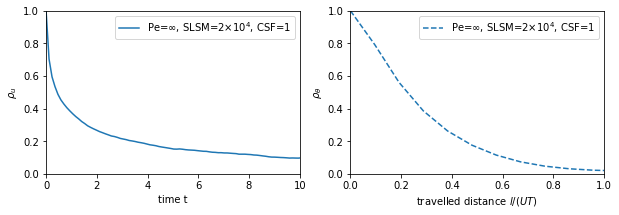

In [25]:
fig, axs = plt.subplots(1,2,figsize=(10,3))

ax = axs[0]
for key in PLOT_KEYS[:1] :
    ax.plot(kv_autocorr[key]*dt_iso[key][0], v_autocorr[key], '-', label = key)
ax.set_xlabel('time t')
ax.set_ylabel(r'$\rho_u$')
ax.set_xlim([0,10])
ax.set_ylim([0,1])
ax.legend();

ax = axs[1]
for key in PLOT_KEYS[:1] :
    ax.plot(kt_autocorr[key]*dl_eq[key][0], theta_autocorr[key], '--', label = key)
ax.set_xlabel(r'travelled distance $l/(UT)$')
ax.set_ylabel(r'$\rho_\theta$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend()
plt.savefig(DIR+'Figures/autocorr'+extension)

In [ ]:
key = KEYS[0]
plt.plot(k_autocorr[key]*dt_iso[key][0], v_autocorr[key], '.-', label = key)
plt.plot(k_autocorr[key]*dt_iso[key][0], theta_autocorr[key], '.-', label = key)

In [ ]:
    Tmax  = 11.0
    dTmax = 1000.0 
    Np    = 200
    start = time.time()
    t_autocorr_, v_autocorr_ = parallel_autocorr(v_iso, Tmax, dTmax, Np)
    end   = time.time()
    print('\tTime needed : '+ str(end-start))    
    #v_iso = {}; dt_iso = {};

In [ ]:
plt.plot(t_autocorr_[KEYS[0]], v_autocorr_[KEYS[0]],'-')
plt.ylim([0,1]);
plt.xlim([0,10]);

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7.5,5.0))
ax.set_title('Uncorrelation time')
a_ = 1.0

for Np in [2, 4, 6] :
    cutting_times = [extract_cutting_time(t_autocorr[key], v_autocorr[key], Np) for key in KEYS]
    ax.plot(D_VALUES_40,  cutting_times[1:N_40+1],'^-', label = 'CSF = 40,  #FDP = '+ str(Np), color = color_cycle[0], alpha = a_)
    ax.plot(D_VALUES_300, cutting_times[N_40+1:],'v-', label = 'CSF = 300, #FDP = '+ str(Np), color = color_cycle[1], alpha = a_)
    a_ /= 1.8

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D_m$')
ax.set_ylabel(r'$\tau_c$[T]')
ax.legend();
plt.savefig(DIR+'Figures/autocorr_time'+extension)

## Modelization of the previous PDF

Behavior of mean log velocity and std are similar to function of the form :

$$ f(y; a_1,a_2,b,c) = \frac{a_1 \exp{[-c(y-b)]} + a_2 \exp{[c(y-b)]}}{\exp{[-c(y-b)]} + \exp{[c(y-b)}]} $$

where $a_1$,$a_2$ are left and right asymptotic behavior, respectively, $b$ the inflexion point position, $c$ the growth rate .

It can be useful to transform $f(x; a_1,a_2,b,c)$ into
$$ f(x; a_1,a_2,B,c) = \frac{a_1 B x^{-c} +  a_2 x^{c}}{B x^{-c} + x^{c}} $$
where $ x = e^y$ and $B = e^{2bc}$

In [17]:
def f(x,a1,a2,B,c) :
    up   = a1 * B * x**(-c) + a2 * x**c
    down = B * x**(-c) + x**c
    return up/down

Parameters found : $ v_a = 8.7, \quad v_d = 6.8, \quad b = \ln 10^{-11} $

In [18]:
x = np.array([d_ for d_ in D_VALUES_40 if d_ > 0])
va = 1.18; vd = -0.7;
b = np.log(1.0e-11); c  = 0.65; 
B = np.exp(2*b*c)
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].set_title('LVM mean')
axs[0].semilogx(x,f(x,va,vd,B,c),'-', label=r'fit with $f$')
axs[0].semilogx(D_VALUES_40,vmean_iso[:N_40],'o', label='Isochronous, CSF = 40', color = color_cycle[1])
axs[0].semilogx(D_VALUES_300,vmean_iso[N_40+1:],'o', label='Isochronous, CSF = 300', color = color_cycle[2])
axs[0].set_ylabel(r'\mu = $\langle v \rangle$')
axs[0].legend();

sm = 1.0; sp = 2.25;
axs[1].set_title('LVM standard deviation')
axs[1].semilogx(x,f(x,sm,sp,B,c),'-', label=r'fit with $f$')
axs[1].semilogx(D_VALUES_40,vstd_iso[:N_40],'o', label='Isochronous, CSF = 40', color = color_cycle[1])
axs[1].semilogx(D_VALUES_300,vstd_iso[N_40+1:],'o', label='Isochronous, CSF = 300', color = color_cycle[2])
axs[1].set_ylabel(r'$\sigma = \langle (v - \langle v \rangle)^2 \rangle$')
axs[1].legend();

axs[2].set_title('LVM skewness')
axs[2].semilogx(D_VALUES_40,vskew_iso[:N_40],'o', label='Isochronous, CSF = 40', color = color_cycle[1])
axs[2].semilogx(D_VALUES_300,vskew_iso[N_40+1:],'o', label='Isochronous, CSF = 300', color = color_cycle[2])
#axs[2].semilogx(x,f(x,sm,sp,B,c),'^--', label=r'fit with $f$')
axs[2].set_ylabel(r'$\alpha = \langle\frac{v-\mu}{\sigma}\rangle^3$');

NameError: name 'D_VALUES_40' is not defined

This behavior represent the variation of the mean of the skew normal pdf
$$ p(v; \mu, \sigma)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(v-\mu)^2}{2\sigma^2}\right](1-\textrm{erf}\left[-\frac{\alpha(v-\mu)}{\sqrt{2}\sigma}\right])$$
The mean, variance and skewness of skew normal pdf are given by 
$$\mu^* = \mu + \beta\sigma,\quad \sigma^* = \sigma \sqrt{ 1-\beta^2} \quad\textrm{and}\quad \alpha^* = \frac{4-\pi}{2}\frac{\beta^3}{(1-\beta^2)^{3/2}} \quad\textrm{with}\quad \beta := \sqrt{\frac{2}{\pi}}\frac{\alpha}{\sqrt{1+\alpha^2}}, $$
respectively

(Skewness defined as $\mathbb{E}\left[\left(\frac{X-\mu^*}{\sigma^*}\right)^3\right]$)

To fit our DNS pdf with skew normal pdf, the parameters $\mu,\sigma,\alpha$ must be set to reproduce the observed mean, variance and skewness of the data.
One can relate the skew normal pdf parameters $\mu,\sigma,\alpha$ to the mean, variance and skewness by inversing previous equations :
$$ \mu = \mu^* - \beta \sigma,\quad \sigma = \frac{\sigma^*}{\sqrt{1-\beta^2}} \quad\textrm{and}\quad \beta = \frac{\omega^*}{\sqrt{1+{\omega^*}^2}} \quad\textrm{with}\quad \omega^* :=\left(\frac{2}{4-\pi}\alpha^*\right)^{1/3}$$

The relation between the skewness $\alpha^*$ and our parameter $\alpha$ can be defined as :
$$  $$

In [19]:
def cbrt(x) :
    if x > 0 :
        return x**(1.0/3.0)
    else :
        return -((-x)**(1.0/3.0))

def beta_p(skew) :
    alpha = alpha_p(skew)
    return np.sqrt(2.0/np.pi)*alpha/np.sqrt(1+alpha**2)

def mu_p(avg, std, skew) :
    return avg - beta_p(skew) * std

def sigma_p(std, skew) :
    if beta_p(skew) < 1 :
        return std/np.sqrt(1-beta_p(skew))
    else :
        return std/np.sqrt(1+beta_p(skew))

def alpha_p(skew) :
    omega = cbrt(1.0*skew/(4.0-np.pi))
    if (1-2.0/np.pi)*omega**2 < 2.0/np.pi :
        return omega/np.sqrt(2.0/np.pi - (1-2.0/np.pi)*omega**2)
    else :
        return omega/np.sqrt(2.0/np.pi + (1-2.0/np.pi)*omega**2)
    
#Skew-normal PDF
def psk(v, avg, std, skew) :
    mu    = mu_p(avg, std, skew)
    sigma = sigma_p(std, skew)
    alpha = alpha_p(skew)
    return 1.0/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))

In [20]:
i = 0
v_stats = {}
for key in KEYS :
    tmp = {}
    tmp['avg']  = vmean_iso[i]
    tmp['std']  = vstd_iso[i]
    tmp['skew'] = vskew_iso[i]
    v_stats[key] = tmp
    i+= 1

In [21]:
def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

NameError: name 'PLOT_KEYS_300' is not defined

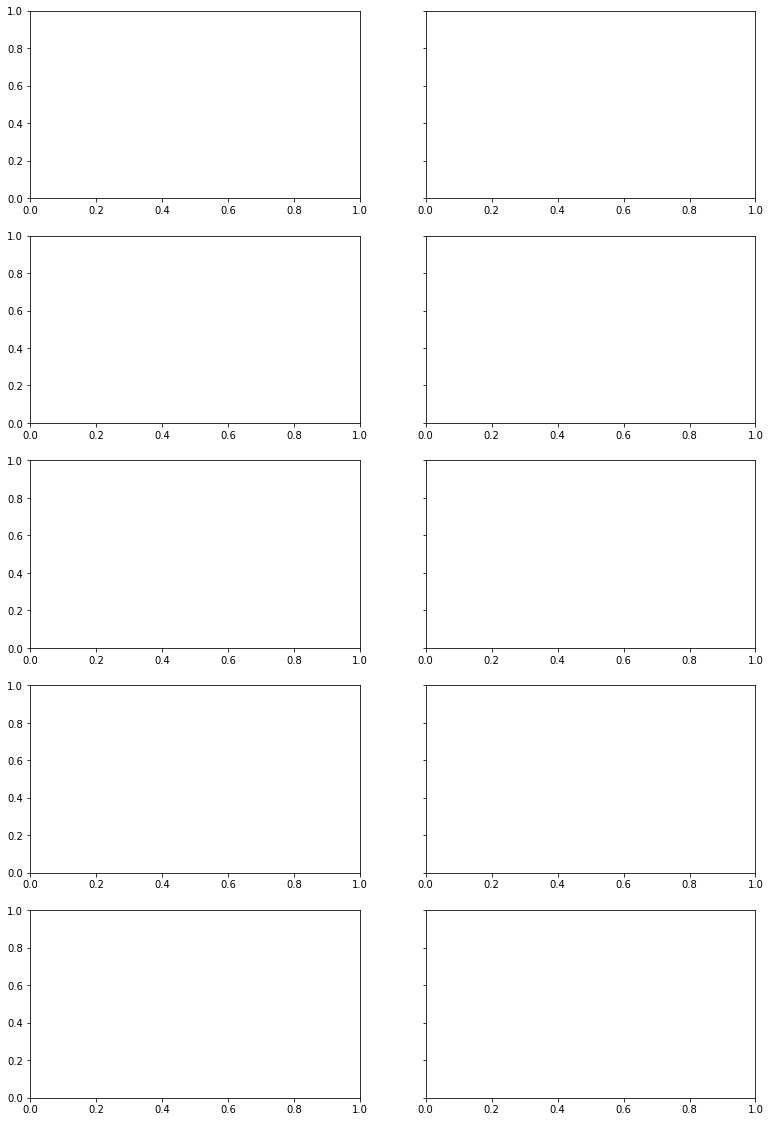

In [22]:
alpha = Bentheimer1000['alpha']
sigma = Bentheimer1000['sigma']
mu = Bentheimer1000['mu']
fig, axs = plt.subplots(5,2, figsize=(13,20), sharey=True);

V = np.linspace(-8,4,1000)
count    = 0
for key in PLOT_KEYS_300 :
    d_ = Extract_param(DATA[key],['DM'])
    (i,j) = (int(count/2),np.mod(count,2))
    ax    = axs[i,j]
    ax.set_title(key);
    ax.plot(pdf_viso[key][0], pdf_viso[key][1])
    avg = v_stats[key]['avg']; std = v_stats[key]['std']; skew = v_stats[key]['skew']
    ax.plot(V, psk(V, avg, std, skew), '--k', label = 'SNP for D = '+str(d_['DM']))
    ax.set_xlim([-8,4])
    ax.set_xlabel('v')
    ax.set_ylabel(r'$p(v)$')
    count += 1
    
plt.savefig(DIR+'Figures/DNS_vs_iso'+extension)

### Comparison with Markovian processes

In [35]:
samples = [Bentheimer1000]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=NCORES_MAX)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Loading data...')
    MP_lvm = Load_data(fname)
    print('Done')

Loading data...
Done


NameError: name 'PLOT_KEYS' is not defined

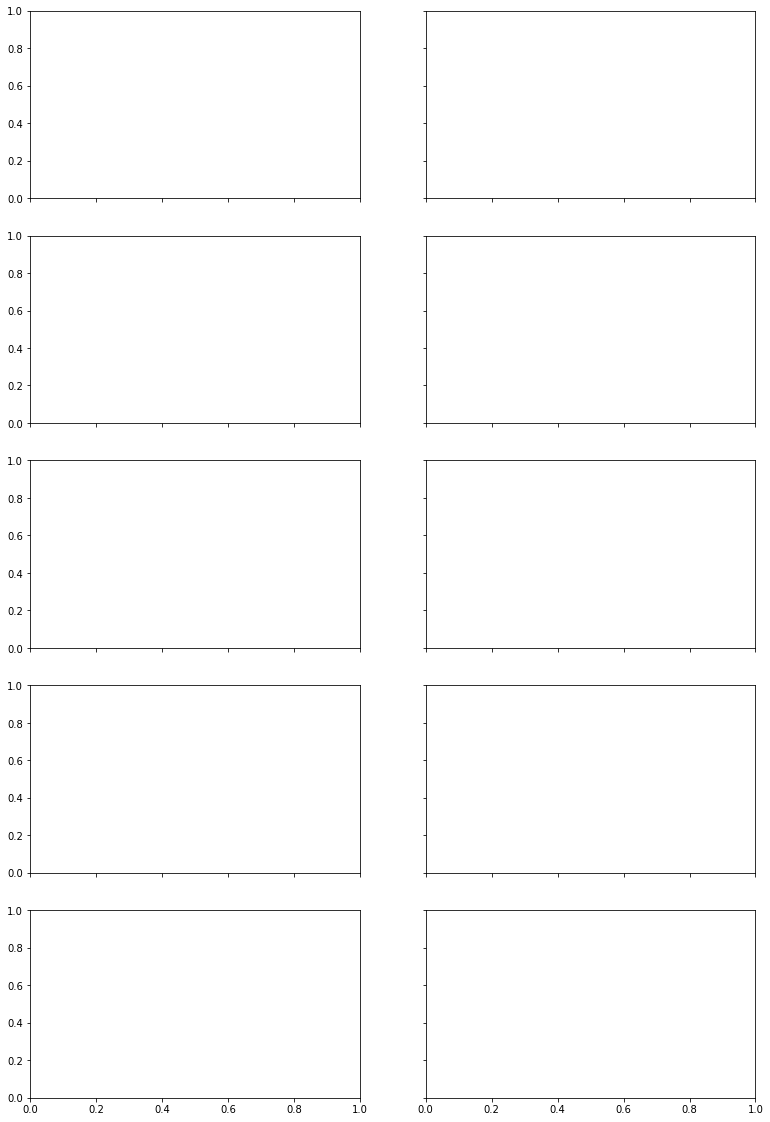

In [36]:
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
fig, axs = plt.subplots(5,2,figsize=(13,20), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in KEYS :
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].set_title('' + key)
    axs[i,j].hist(data1, bins = 200, label = key+' DNS',         density = True, alpha= 0.5)
    axs[i,j].hist(data2, bins = 200, label = key+' Isochronous', density = True, alpha= 0.5)
    axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5)
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000');
    axs[i,j].plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Flow velocity distribution', alpha=0.7);
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    axs[i,j].set_xlim([-8,4])
    count += 1
del data1, data2, data3
plt.savefig(DIR+'Figures/summary'+extension)